# Ejemplo: Aprendizaje no supervisado para spike sorting

### Traducido y adaptado del tutorial de [Christophe Pouzat](https://core.ac.uk/download/pdf/52193212.pdf) por [Daniel Herrera-Esposito](https://dherrera1911.github.io/) 

## Introducción al problema

En este ejemplo veremos un análisis común de datos neuronales, el spike sorting, que aplica algunas de las técnicas de aprendizaje no supervisado que hicimos.

Este análisis se usa para procesar los datos de registros neuronales extracelulares. En estos registros se usan 4 electrodos juntos (un tétrodo), donde cada electrodo registra los cambios de voltaje en el ambiente producidos por la actividad neuronal. Cuando una neurona se activa, genera un potencial de acción, o **spike**, que es una subida y bajada rápida del voltaje.

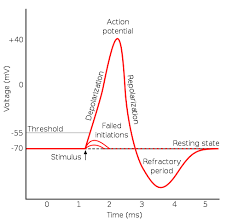

En estos registros neuronales, el electrodo mide el voltaje a lo largo del tiempo, y el objetivo del análisis es detectar cuando una neurona genera un spike. Para esto, lo primero que hace el análisis es detectar los spikes entre el ruido del electrodo. Luego, es frecuente que los electrodos capten los spikes de varias neuronas a su alrededor. Otro objetivo del análisis es identificar cuantas neuronas se están captando, y asignar los spikes a cada neurona.

A continuación, veremos cómo se resuelve este análisis. El tutorial se basa en [este tutorial](https://core.ac.uk/download/pdf/52193212.pdf) de spike sorting, con [código disponible aquí](https://c_pouzat.gitlab.io/spike-sorting-the-diy-way/), elaborado por Christophe Pouzat.

El análisis consiste en los siguientes pasos:
* Preprocesamiento para detectar spikes
* Reducir dimensionalidad de registros de spikes
* Aplicar clustering

## Cargada de código e imágenes

Comenzamos cargando algo de código auxiliar que viene con el tutorial

In [11]:
import numpy as np
import matplotlib.pylab as plt
!wget -O sorting_with_python.py https://gitlab.com/c_pouzat/spike-sorting-the-diy-way/-/raw/master/org/code/sorting_with_python.py?ref_type=heads
import sorting_with_python as swp

--2024-08-08 18:39:48--  https://gitlab.com/c_pouzat/spike-sorting-the-diy-way/-/raw/master/org/code/sorting_with_python.py?ref_type=heads
Resolving gitlab.com (gitlab.com)... 2606:4700:90:0:f22e:fbec:5bed:a9b9, 172.65.251.78
Connecting to gitlab.com (gitlab.com)|2606:4700:90:0:f22e:fbec:5bed:a9b9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24014 (23K) [text/plain]
Saving to: ‘sorting_with_python.py’

sorting_with_python 100%[===================>]  23.45K  --.-KB/s    in 0.001s  

2024-08-08 18:39:49 (32.2 MB/s) - ‘sorting_with_python.py’ saved [24014/24014]



In [12]:
# Fijar algunos parametros de las graficas
plt.rcParams['figure.figsize'] = [15, 12]
plt.ion()

Luego cargamos los datos. Tenemos 4 archivos, cada uno correspondiente a un electrodo del tétrodo.

In [13]:
from urllib.request import urlretrieve # Python 3
# from urllib import urlretrieve # Python 2
data_names = ['Locust_' + str(i) + '.dat.gz' for i in range(1,5)]
data_src = ['http://xtof.disque.math.cnrs.fr/data/' + n
            for n in data_names]
[urlretrieve(data_src[i],data_names[i]) for i in range(4)]

# descomprimimos los archivos
from os import system
[system("gunzip " + fn) for fn in data_names]

[0, 0, 0, 0]

Cargamos los datos en la lista data y los imprimimos para verlos.

In [14]:
# Create a list with the file names
data_files_names = ['Locust_' + str(i) + '.dat' for i in range(1,5)]
# Get the lenght of the data in the files
data_len = np.unique(list(map(len, map(lambda n:
                                       np.fromfile(n,np.double),
                                       data_files_names))))[0]
# Load the data in a list of numpy arrays
data = [np.fromfile(n,np.double) for n in data_files_names]

print("Los están en una lista conteniendo 4 vectores de medidas de voltaje")
print(data)
print(f"Cada electrodo cuenta con {len(data[0])} medidas")

Los están en una lista conteniendo 4 vectores de medidas de voltaje
[array([ 0.38682583, -0.29757836, -0.97527272, ..., -0.81423643,
       -1.08934008, -0.30428821]), array([ 0.13847187, -0.95567365, -0.11897414, ..., -0.67983865,
       -1.20392516, -0.13736314]), array([ 0.07678422,  0.6117637 ,  0.31455288, ..., -1.08828221,
       -1.17150124, -0.33931093]), array([-0.72246517, -1.34737791, -0.74169326, ..., -0.70323709,
       -0.95320219, -0.95320219])]
Cada electrodo cuenta con 300000 medidas


Luego graficamos los registros de voltaje, graficando cada electrodo en un trazo distinto. También graficamos una ampliación de los trazos, para ver la estructura más fina.

(0.0, 0.2)

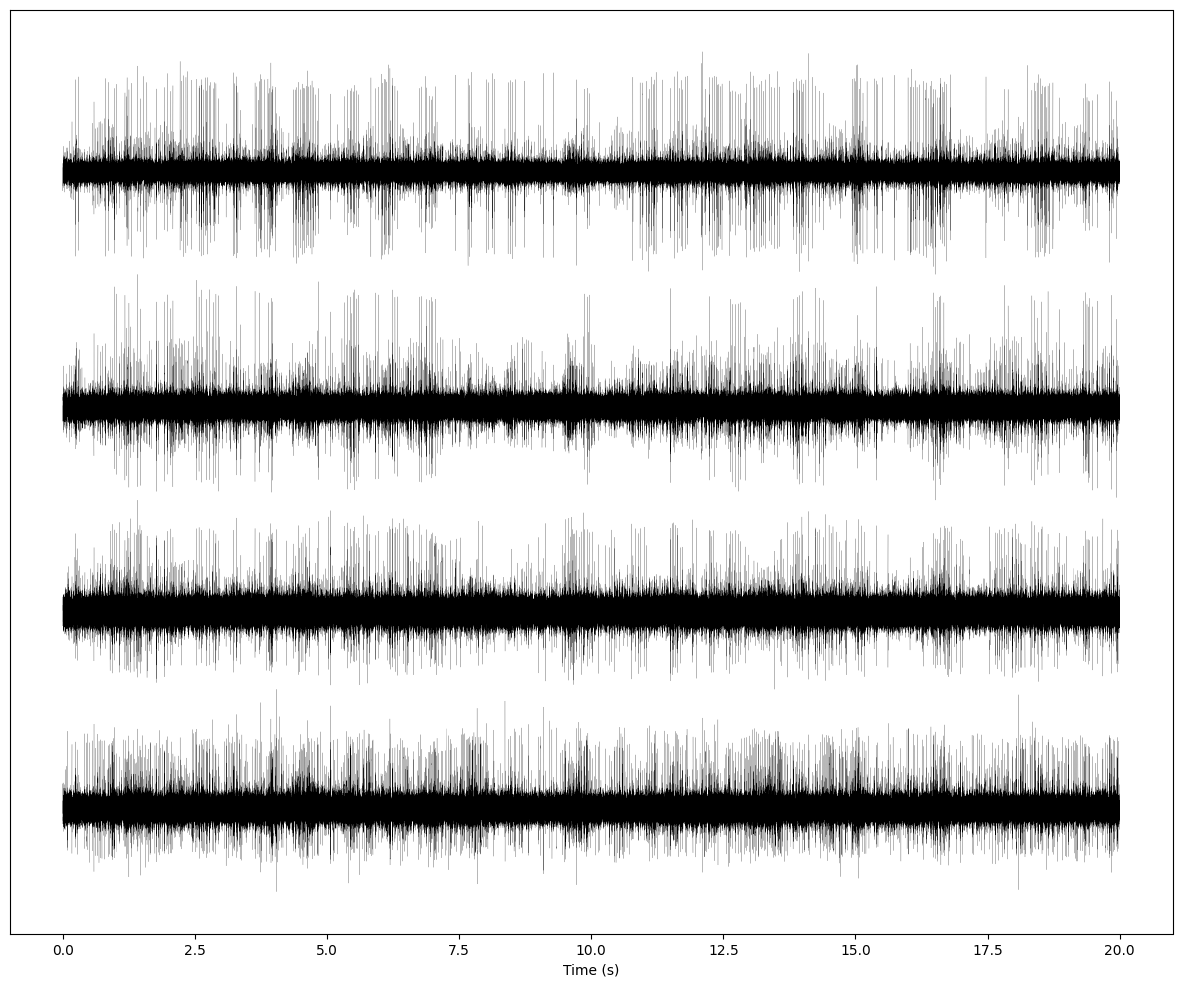

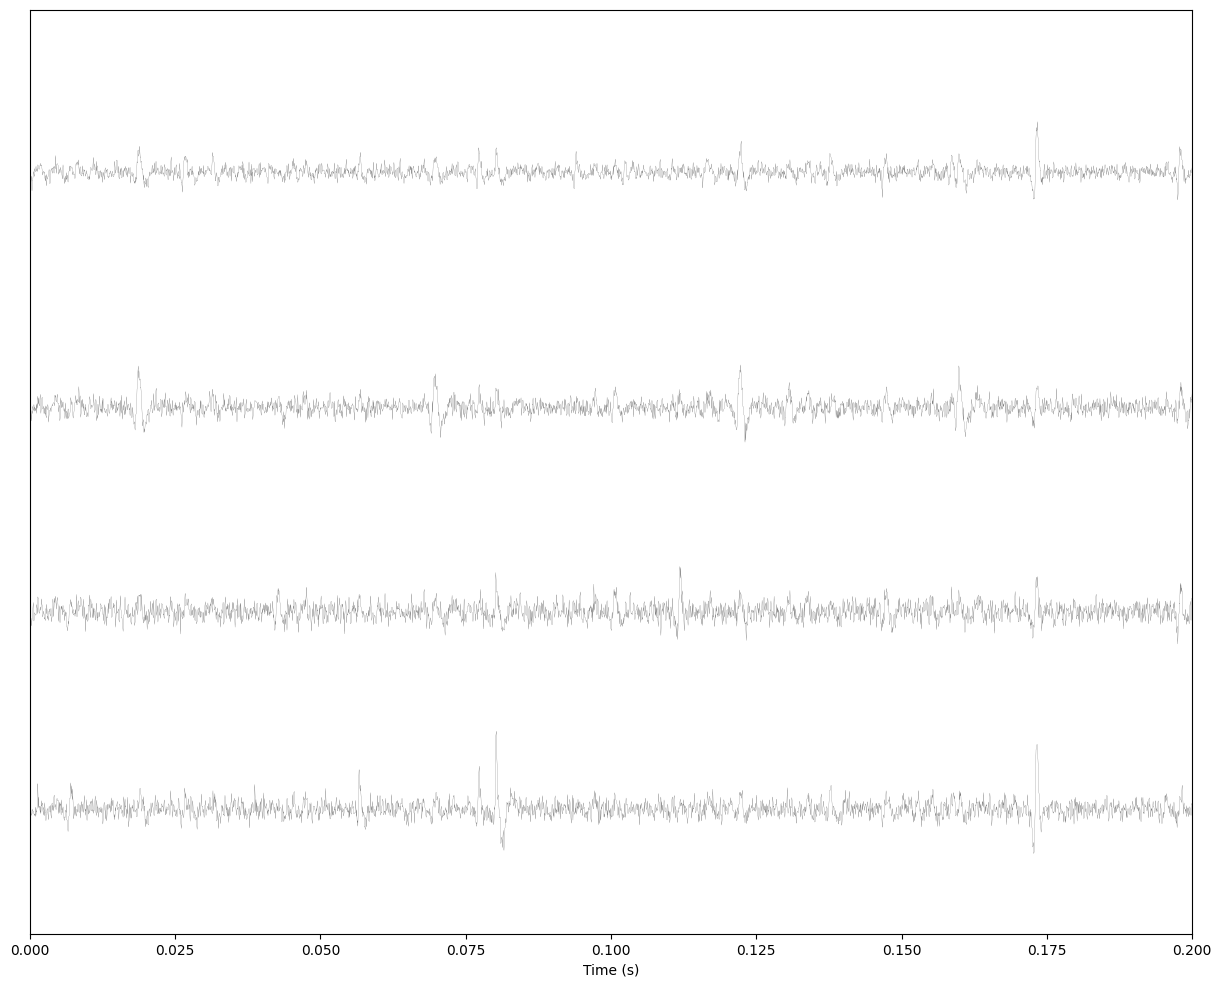

In [15]:
# Hago un vector con los tiempos, sabiendo la frecuencia de muestreo
time = np.arange(0,data_len)/1.5e4
plt.figure()
# Grafico los trazos
swp.plot_data_list(data,time,0.1)
plt.figure()
# Grafico zoomeado
swp.plot_data_list(data,time,0.1)
plt.xlim([0,0.2])

## Preprocesamiento de los datos, detección de spikes

Luego normalizamos los datos intentando que el nivel de ruido tenga magnitud igual a 1. Para ello usamos, en vez del desvío estándar de los datos, el Median Absolute Deviation, una estadística más robusta a los outliers.

In [16]:
# Le aplico la normalización por el MAD a los datos
data = list(map(lambda x: (x-np.median(x))/swp.mad(x), data))

Graficamos cómo quedan los datos, y comparamos el nivel de ruido estimado con MAD (rojo) y el nivel estimado con el desvío estándar (azul).

(-5.0, 10.0)

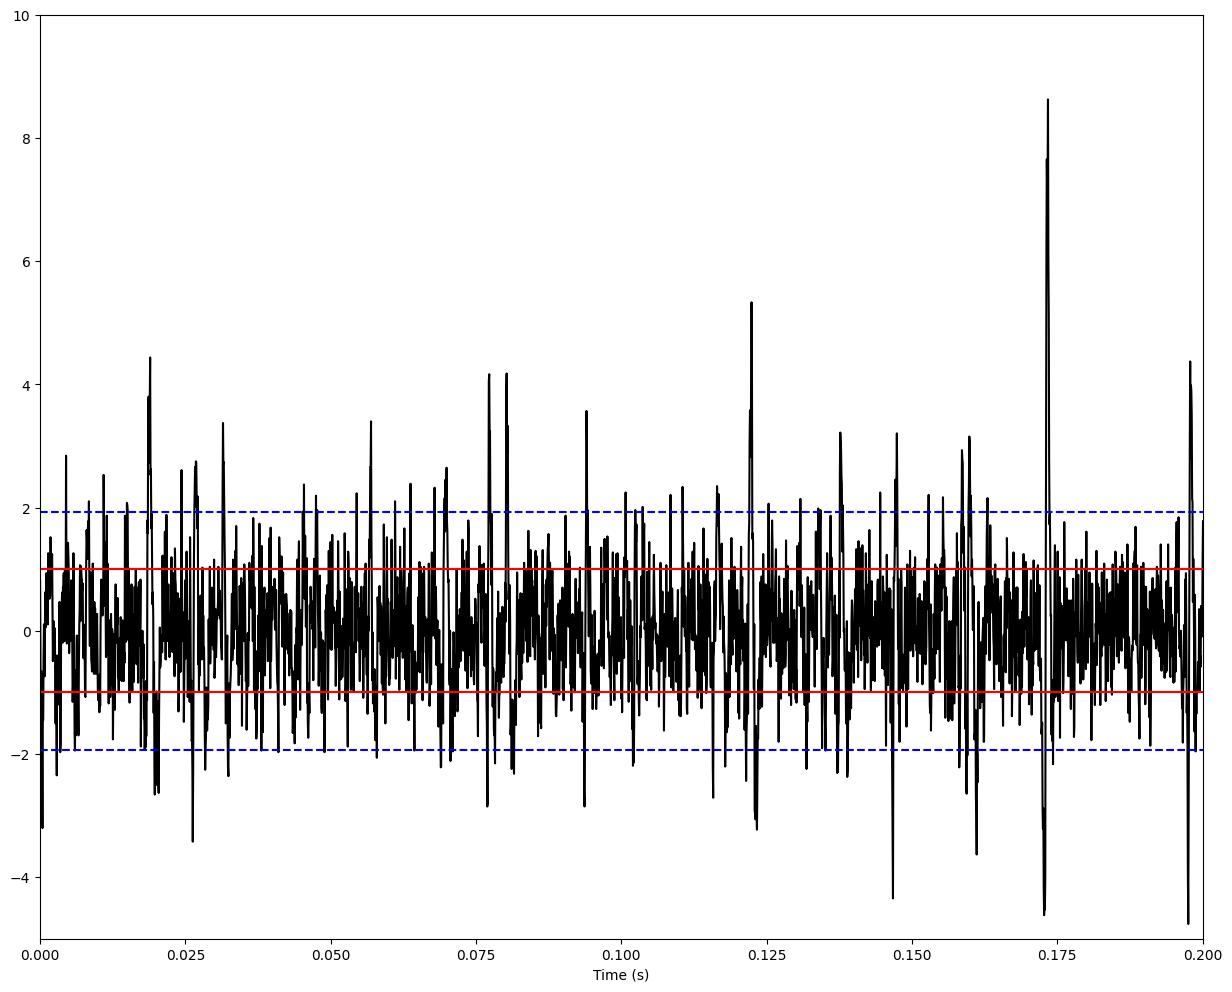

In [17]:
# Grafico los datos normalizados
plt.plot(time, data[0], color="black")
plt.xlim([0,0.2])
plt.ylim([-17,13])
# Agrego una línea roja mostrando el nivel de ruido estimado por MAD
plt.axhline(y=1, color="red")
plt.axhline(y=-1, color="red")
# Agrego una línea azul mostrando el nivel de ruido estimado por SD
plt.axhline(y=np.std(data[0]), color="blue", linestyle="dashed")
plt.axhline(y=-np.std(data[0]), color="blue", linestyle="dashed")
plt.xlabel('Time (s)')
plt.ylim([-5,10])

A continuación suavizamos los datos, cambiando a cada punto por el promedio del punto y sus 4 vecinos más cercanos (2 a cada lado). Luego, seteamos los valores menores que 4 MAD (4 veces el nivel del ruido) en 0.

In [18]:
from scipy.signal import fftconvolve
from numpy import apply_along_axis as apply

# Filtro los datos, suavizandolos
data_filtered = apply(lambda x:
                      fftconvolve(x,np.array([1,1,1,1,1])/5.,'same'),
                      1,np.array(data))
# Vuelvo a aplicar la normalización por MAD
data_filtered = (data_filtered.transpose() / \
                 apply(swp.mad,1,data_filtered)).transpose()
# Convierto en 0 los valores que no superan el umbral
data_filtered[data_filtered < 4] = 0

Abajo visualizamos el resultado del suavizado y de aplicar el umbral. En rojo se muestra el trazo suavizado, y en negro el trazo original. Mostramos también en azul el umbral que usaremos para detectar la ocurrencia de picos, que es cuando el voltaje supera 4 veces el nivel del ruido (calculado luego del filtrado).

Text(0.5, 0, 'Time (s)')

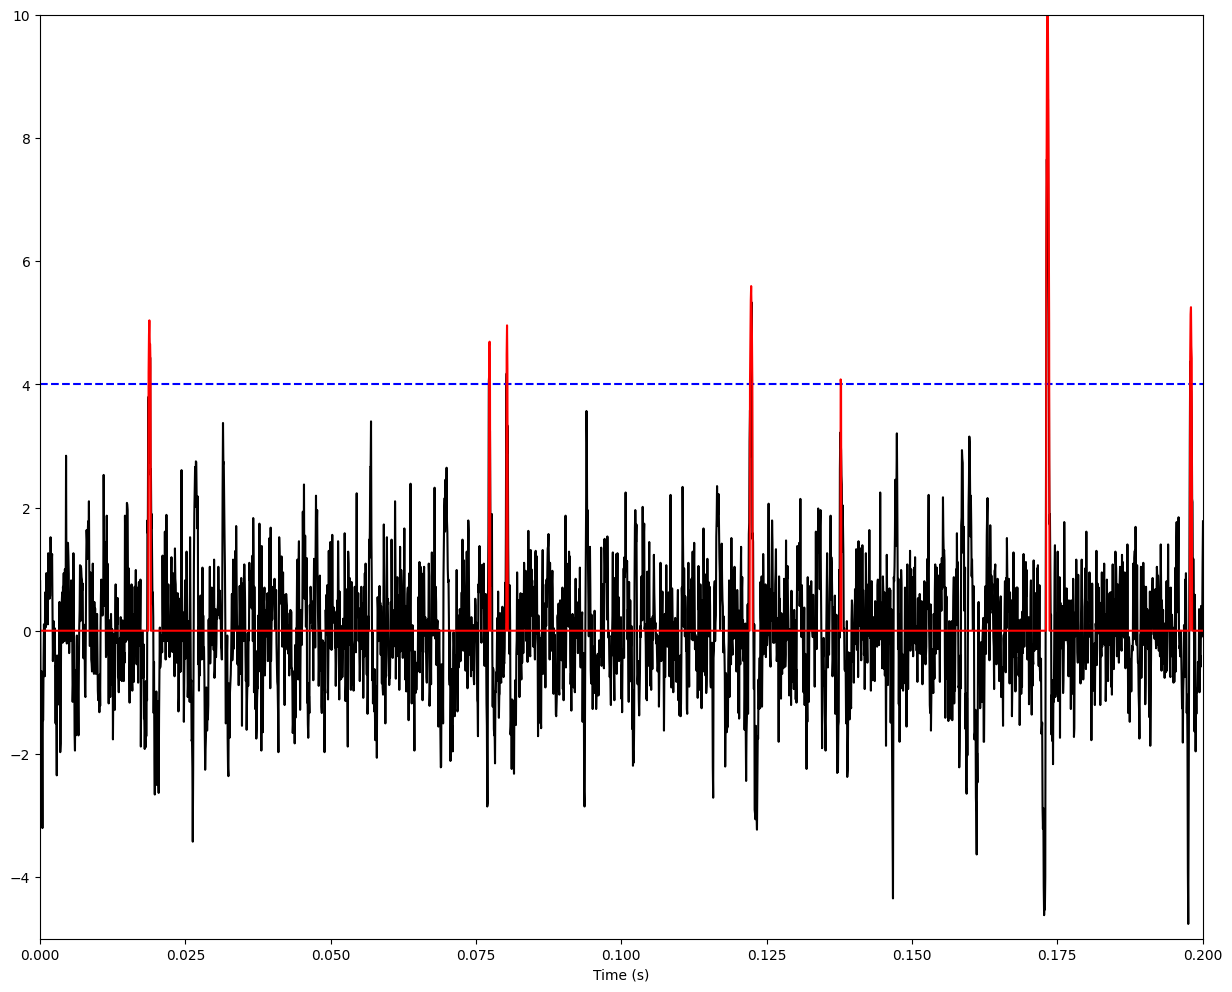

In [19]:
plt.plot(time, data[0], color='black')
plt.axhline(y=4, color="blue", linestyle="dashed")
plt.plot(time, data_filtered[0,], color='red')
plt.xlim([0,0.2])
plt.ylim([-5,10])
plt.xlabel('Time (s)')

Vemos que esporádicamente ocurren picos que superan el umbral. Aplicamos una función que detecta los picos en la señal suavizada, e imprimimos sp0 el vector que contiene el índice en que ocurre cada pico.

In [20]:
# Obtengo los tiempos de los picos a partir de los datos filtrados
sp0 = swp.peak(data_filtered.sum(0))
print(sp0)
print(f"Detectamos un total de {len(sp0)} spikes en los registros")

[   281    851   1045 ... 299400 299434 299545]
Detectamos un total de 1795 spikes en los registros


Abajo graficamos los eventos detectados superpuesto con el registro original. Notar que un pico se puede detectar en cualquiera de los 4 electrodos, pero se marca como pico en todos los electrodos, incluso los que no detectan a esa neurona.

(0.0, 0.2)

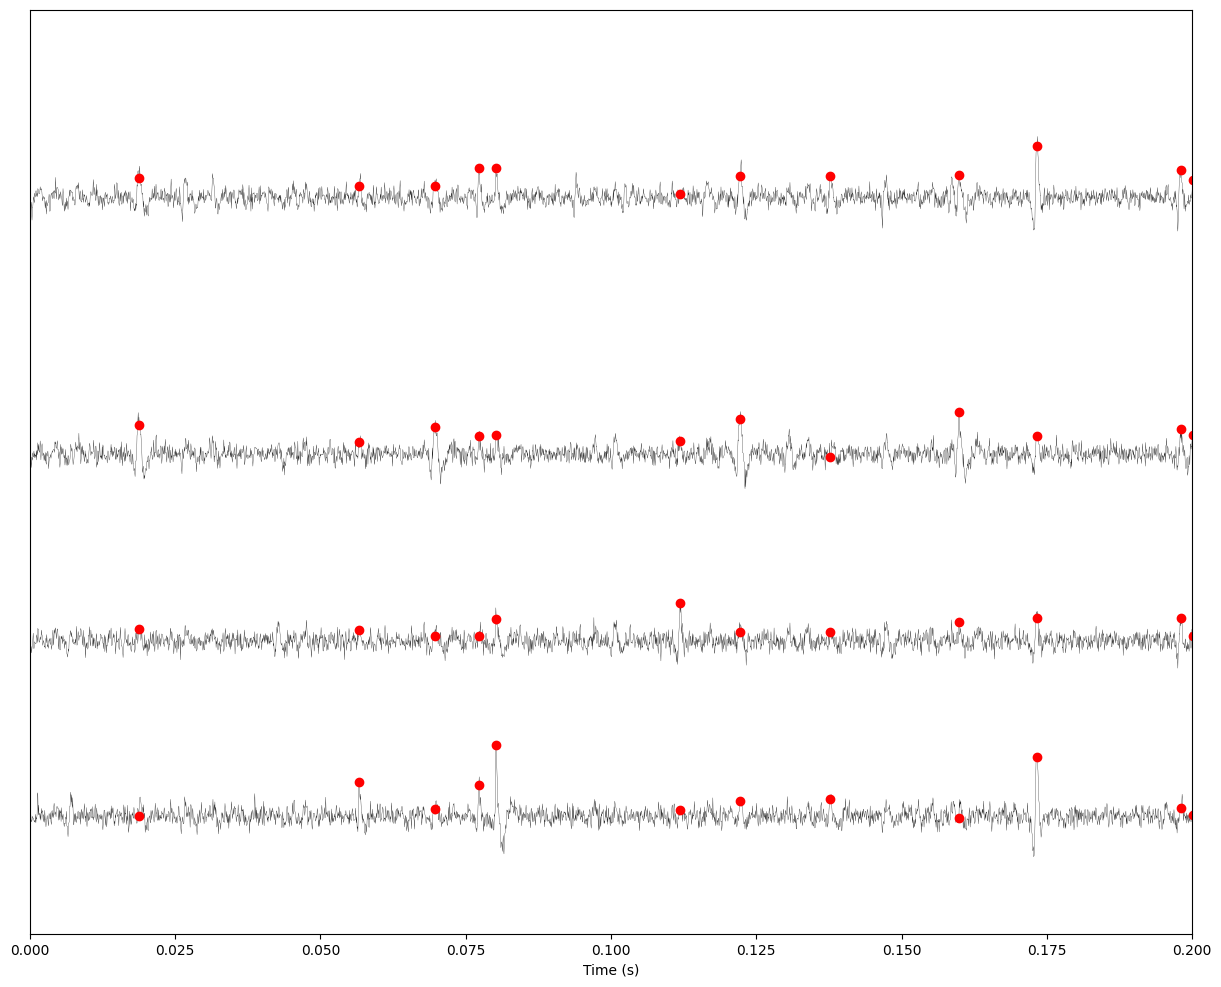

In [21]:
# Grafico los tiempos en que se detectaron picos, sobre el registro original
swp.plot_data_list_and_detection(data, time, sp0)
plt.xlim([0,0.2])

## Preprocesamiento de datos 2: Extraer la "foto" de cada pico

Ahora que detectamos los spikes en los registros, queremos usar la forma de los picos para agruparlos según su origen. Lo primero que tenemos que hacer es "sacarle una foto" a cada spike, es decir, cortar un pedazo de registro en torno al spike.

In [22]:
# Genero una lista conteniendo los 50ms de registr previos y posteriores a cada pico
evtsE = swp.mk_events(sp0, np.array(data), 14, 35)
print(evtsE)
print(f"Cada spike tiene {len(evtsE[0])} puntos, {int(len(evtsE[0])/4)} por cada electrodo")
print(f"Tenemos {len(evtsE)} eventos en el set de entrenamiento")

[[-0.22050659 -1.42680738 -1.45274933 ...  0.28103782 -0.47776429
   0.82906156]
 [-0.41507124  0.93391028  0.12970976 ...  0.99768425 -0.47776429
   0.39345294]
 [-0.46695514 -1.089562   -1.58245909 ... -1.32087774 -0.56207563
  -0.43560862]
 ...
 [ 0.8171715  -0.19456464 -0.31130343 ...  5.59265255  8.27656369
   9.09157336]
 [-1.29709761  0.11673879 -0.64854881 ...  0.21077836 -0.67449076
   0.85716534]
 [-0.89499735 -0.95985223 -0.85608443 ...  0.42155672  2.07967984
   0.56207563]]
Cada spike tiene 200 puntos, 50 por cada electrodo
Tenemos 1795 eventos en el set de entrenamiento


Luego, queremos obtener el "pico promedio" de los picos obtenidos, para ver que la ventana que elegimos para cortar sea adecuada. Visualizamos la mediana de los picos (rojo), y la desviación mediana (MAD) del voltaje promedio para cada punto (azul). En rojo entonces vemos la forma promedio de los picos, y en azul vemos cuando las variaciones vuelven al nivel del ruido (MAD = 1, por la normalización realizada)

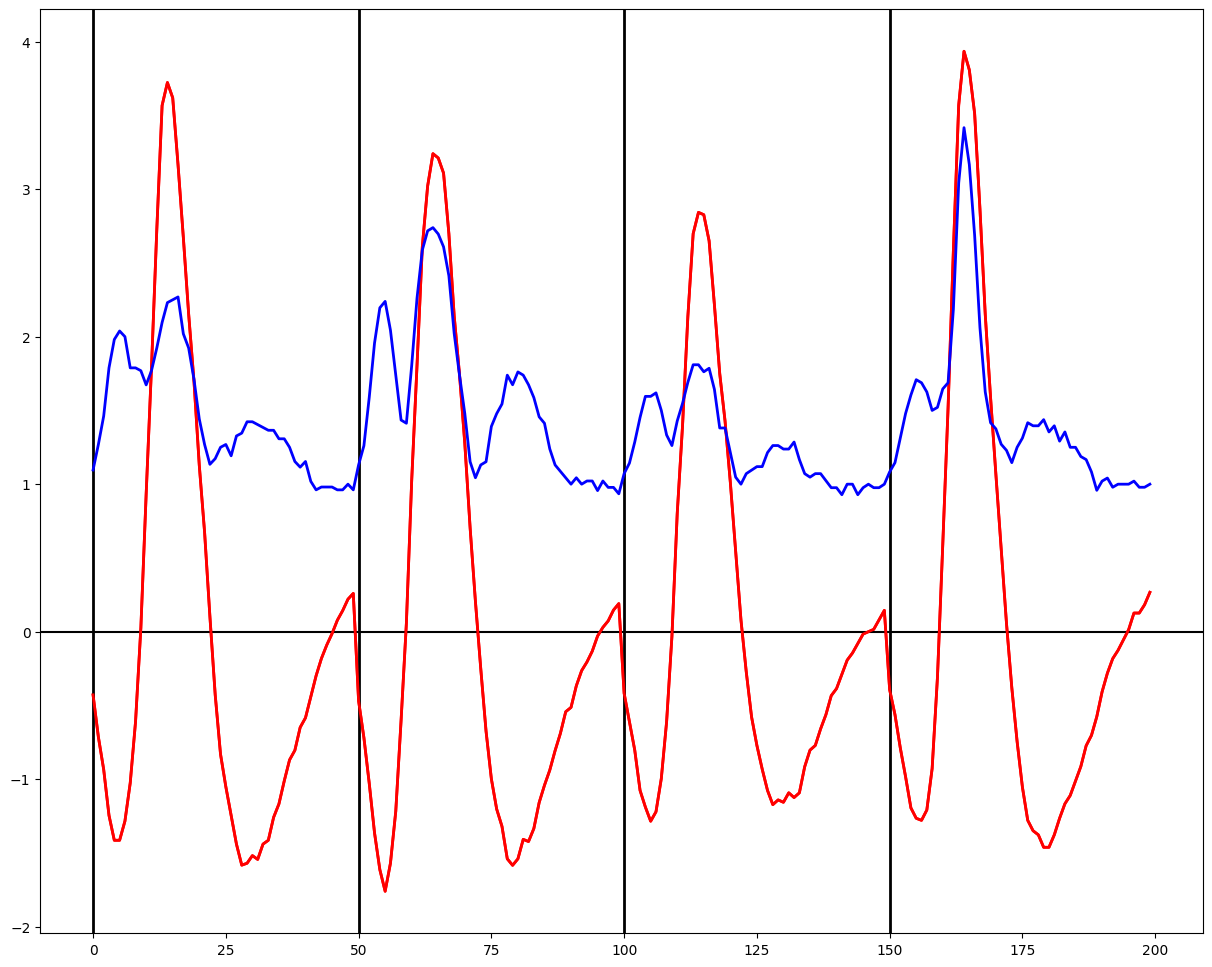

In [23]:
# Computo el voltaje mediano en cada punto
evtsE_median = apply(np.median, 0, evtsE)
# Computo el desvío absoluto mediano para cada punto
evtsE_mad = apply(swp.mad, 0, evtsE)

# Grafico desvío absoluto mediano y el voltaje mediano de cada punto
plt.plot(evtsE_median, color='red', lw=2)
plt.axhline(y=0, color='black')
for i in np.arange(0,200,50):
    plt.axvline(x=i, color='black', lw=2)

plt.plot(evtsE_median, color='red', lw=2)
plt.plot(evtsE_mad, color='blue', lw=2)

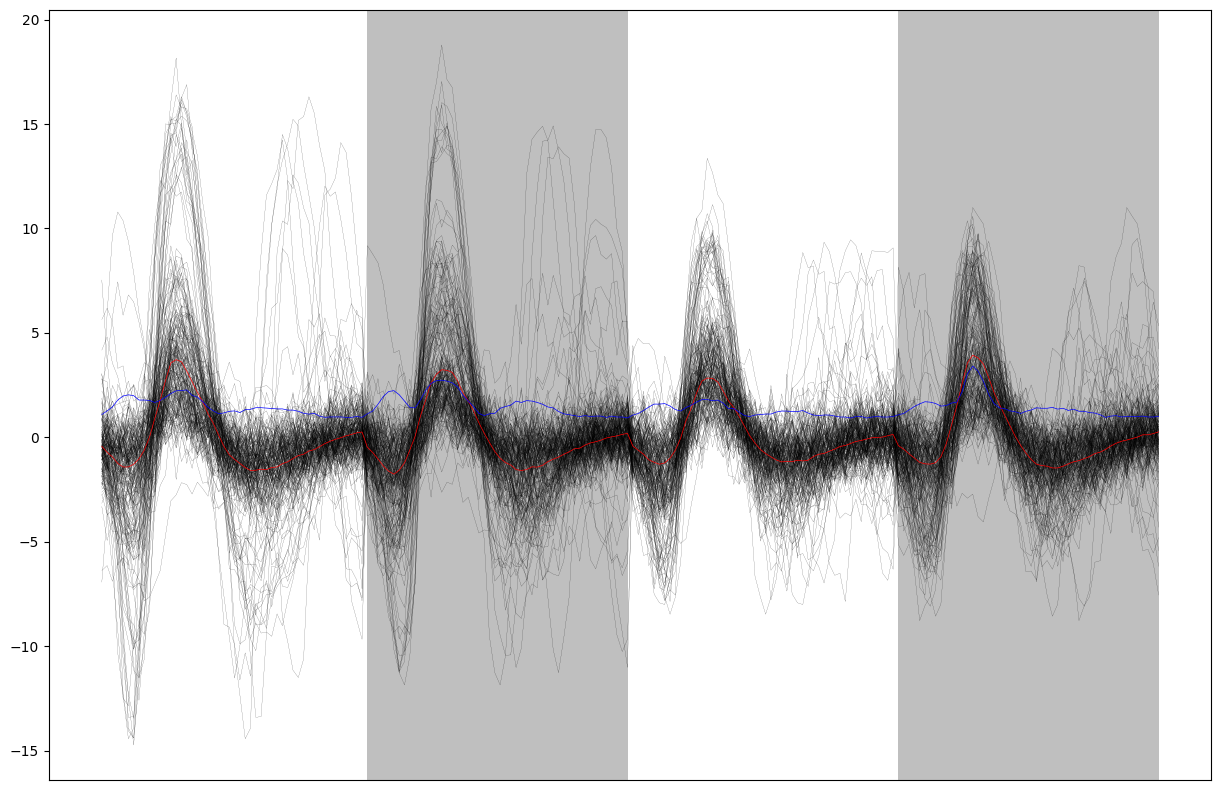

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]
swp.plot_events(evtsE,200)

Vemos algunos trazos donde se ven dobles picos. Esto ocurre cuando 2 neuronas disparan de forma muy superpuesta. A continuación eliminamos esos trazos del análisis (en el tutorial original se procesan y se reincorporan, pero aquí lo hacemos más simple).

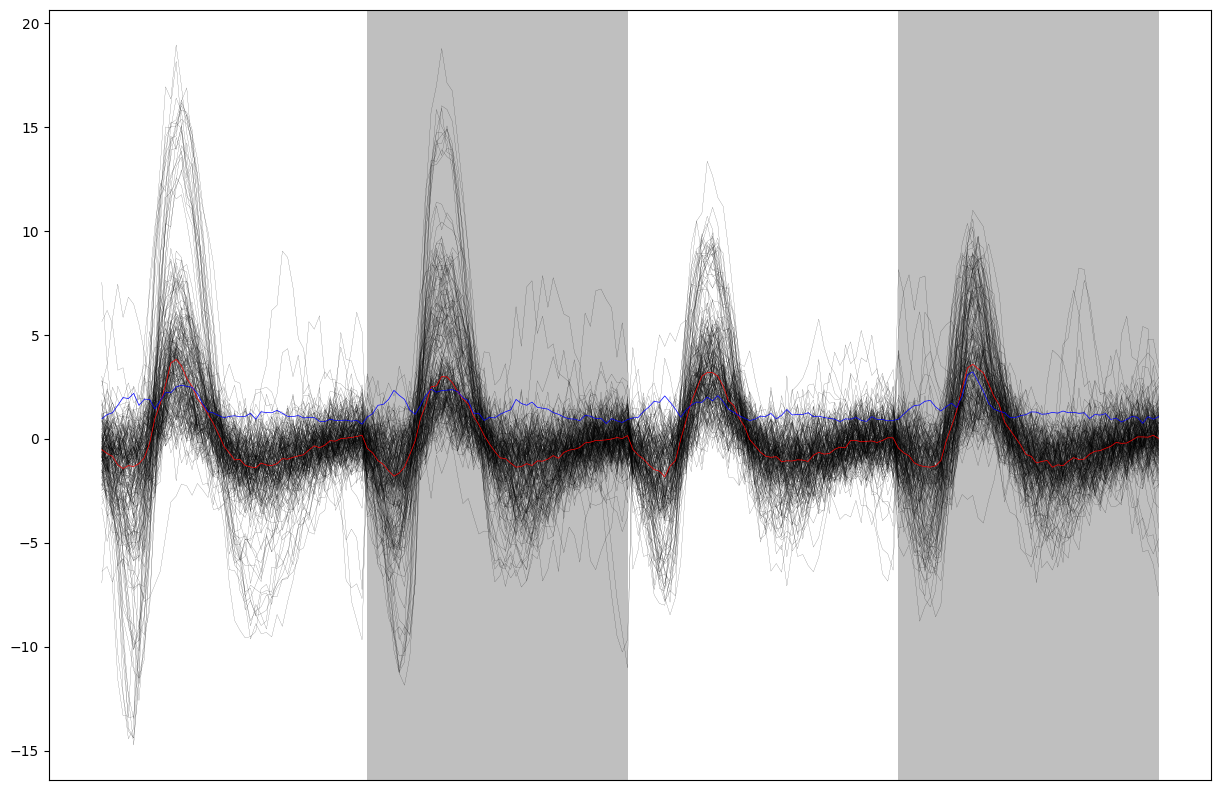

In [25]:
def good_evts_fct(samp, thr=3):
    samp_med = apply(np.median,0,samp)
    samp_mad = apply(swp.mad,0,samp)
    above = samp_med > 0
    samp_r = samp.copy()
    for i in range(samp.shape[0]): samp_r[i,above] = 0
    samp_med[above] = 0
    res = apply(lambda x:
                np.all(abs((x-samp_med)/samp_mad) < thr),
                1,samp_r)
    return res

# Busco los eventos que no tiene superposicion
goodEvtsInds = good_evts_fct(evtsE,8)
# Me quedo sólo con esos y los grafico
goodEvts = evtsE[goodEvtsInds,:]
sp0 = sp0[goodEvtsInds]
swp.plot_events(goodEvts[:200,:])

## Reducción de dimensionalidad

Ahora, cada uno de los picos extraídos cuenta con 200 dimensiones: 50 puntos de tiempo para cada uno de los 4 electrodos. Para aplicar la técnica de clustering que agrupe los picos es conveniente reducir la dimensionalidad de los datos.

Para ello, realizamos un PCA sobre nuestros datos.

In [26]:
from sklearn.decomposition import PCA
pca_puntaje = PCA()
# Ajusto el PCA a los registros de los spikes
pca_puntaje.fit(goodEvts)

PCA()

Podemos extraer y visualizar los componentes principales de los datos. Abajo graficamos el voltaje medio de los picos en cada electrodo (negro), y el resultado de sumarle (rojo) o restarle (azul) cada componente principal.

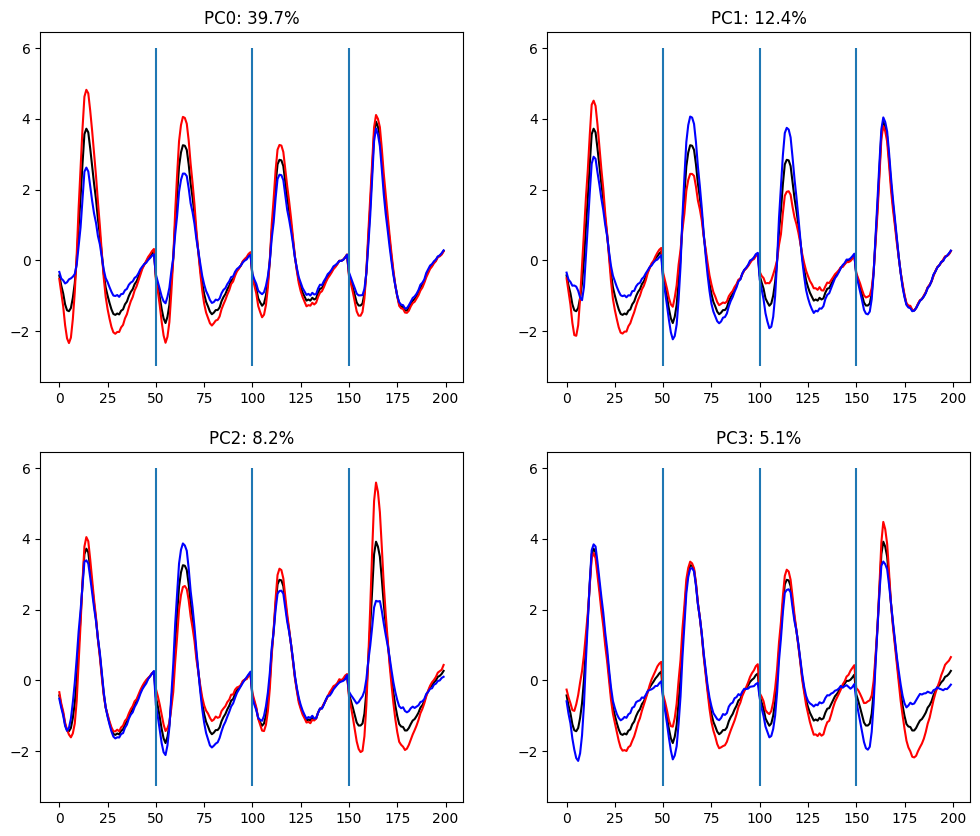

In [27]:
# Grafico los primeros 4 componentes principales, sumados o restados al spike mediano
evt_idx = range(goodEvts.shape[1])
evtsE_good_mean = np.median(goodEvts,0)
plt.figure(figsize=(12,10))
for i in range(4):
  PC = pca_puntaje.components_[i,:]
  plt.subplot(2,2,i+1)
  plt.plot(evt_idx, evtsE_good_mean, 'black', evt_idx,
           evtsE_good_mean + 5 * PC,
           'red',evt_idx,evtsE_good_mean - 5 * PC, 'blue')
  plt.title('PC' + str(i) + ': ' + str(np.round(pca_puntaje.explained_variance_ratio_[i]*100, decimals=1)) +'%')
  plt.vlines(x=(50,100,150), ymin=-3, ymax=6)


Vemos, por ejemplo, que diferentes PC capturan lo que ocurre en diferentes electrodos. Por ejemplo, el PC0 captura la amplitud de los electrodos 1 al 3 (es decir, un spike con mayor valor en el PC0 tiene más altos estos 3 picos). Un spike con alto valor en PC1, por ejemplo, tiene un mayor pico en el electrodo 1, pero menor pico en el 2 y el 3. Un spike con alto valor en el PC3 tiene un primer valle menos pronunciado, y un segundo valle más pronunciado.

A continuación, imprimimos la varianza explicada por cada PC, a ver con cuantos nos quedamos.

In [28]:
# Extraigo un vector con el % de varianza explicada por cada PC
print("El porcentaje de la varianza explicada por los primeros 20 PC es:")
print(np.round(pca_puntaje.explained_variance_ratio_[0:20]*100, decimals=1))

El porcentaje de la varianza explicada por los primeros 20 PC es:
[39.7 12.4  8.2  5.1  4.6  3.2  2.4  1.9  1.4  1.3  0.9  0.8  0.8  0.8
  0.6  0.5  0.4  0.4  0.3  0.3]


Nos quedamos con los 10 primeros PC, que son los que explican más de un 1% de la varianza. En el tutorial original el número de PC se elige mirando la varianza de los datos que corresponde al ruido (método más riguroso), que también da 10 PC.

In [29]:
# Transformo los datos de los spikes al espacio de los PC
spikesPC = pca_puntaje.transform(goodEvts)
# Y me quedon con los primeros 10 PC
spikesPC = spikesPC[:,0:10]

## Clustering de los spikes

Ahora que redujimos la dimensión de los spikes, pasándolos del registro completo a 10 PC, graficamos los spikes en un scatterplot mostrando los primeros 4 PC.

array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>,
        <Axes: xlabel='2', ylabel='0'>, <Axes: xlabel='3', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>,
        <Axes: xlabel='2', ylabel='1'>, <Axes: xlabel='3', ylabel='1'>],
       [<Axes: xlabel='0', ylabel='2'>, <Axes: xlabel='1', ylabel='2'>,
        <Axes: xlabel='2', ylabel='2'>, <Axes: xlabel='3', ylabel='2'>],
       [<Axes: xlabel='0', ylabel='3'>, <Axes: xlabel='1', ylabel='3'>,
        <Axes: xlabel='2', ylabel='3'>, <Axes: xlabel='3', ylabel='3'>]],
      dtype=object)

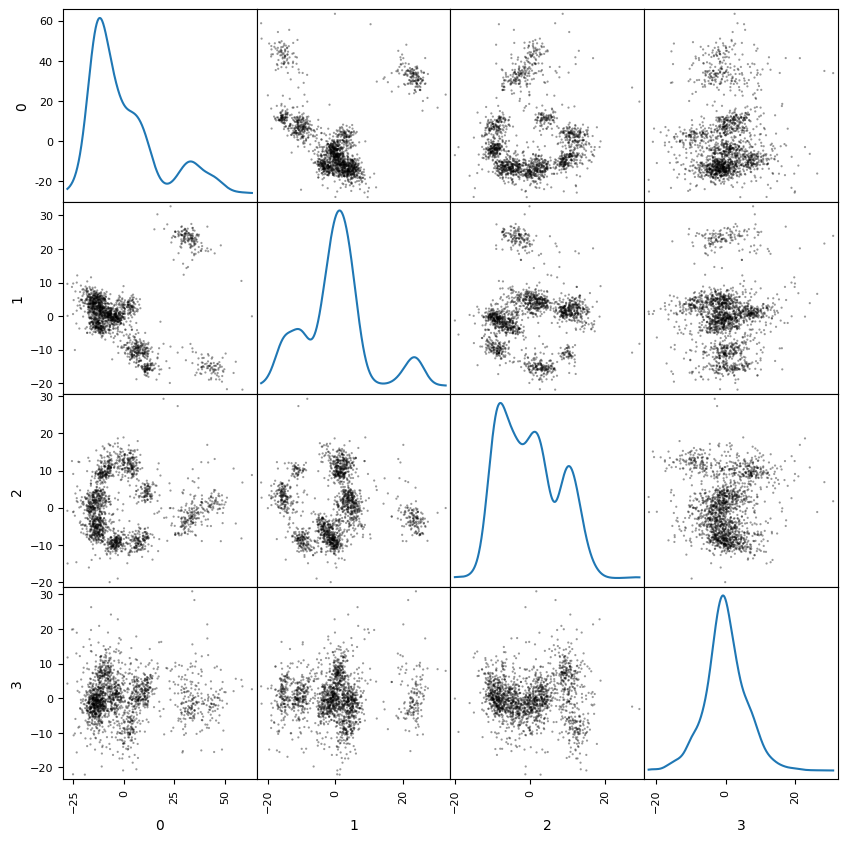

In [30]:
from pandas.plotting import scatter_matrix
import pandas as pd
df = pd.DataFrame(spikesPC[:,0:4])
scatter_matrix(df,alpha=0.4,s=10,c='k',figsize=(10,10),
               diagonal='kde',marker=".")


Vemos que claramente los spikes se dividen en diferentes clusters. Aplicaremos K vecinos más cercanos (KNN) para clasificar a cada spike según el grupo al que pertenece.

Primero tenemos que elegir el número de clusters, para eso probamos el algoritmo con diferentes valores de K, buscando si hay alguna diferencia cualitativa.

/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/p

K 1 score -1010285.4 variación relativa  0%
K 2 score -629402.8 variación relativa 38%
K 3 score -499716.0 variación relativa 21%
K 4 score -403902.9 variación relativa 19%
K 5 score -336836.2 variación relativa 17%
K 6 score -301165.0 variación relativa 11%


/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/p

K 7 score -267152.2 variación relativa 11%
K 8 score -245516.6 variación relativa  8%
K 9 score -228258.8 variación relativa  7%
K 10 score -214262.6 variación relativa  6%


/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K 11 score -207205.9 variación relativa  3%
K 12 score -201464.4 variación relativa  3%
K 13 score -198986.6 variación relativa  1%
K 14 score -192425.9 variación relativa  3%
K 15 score -188679.0 variación relativa  2%


/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K 16 score -185588.6 variación relativa  2%
K 17 score -182105.1 variación relativa  2%
K 18 score -178738.3 variación relativa  2%


/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K 19 score -174852.1 variación relativa  2%


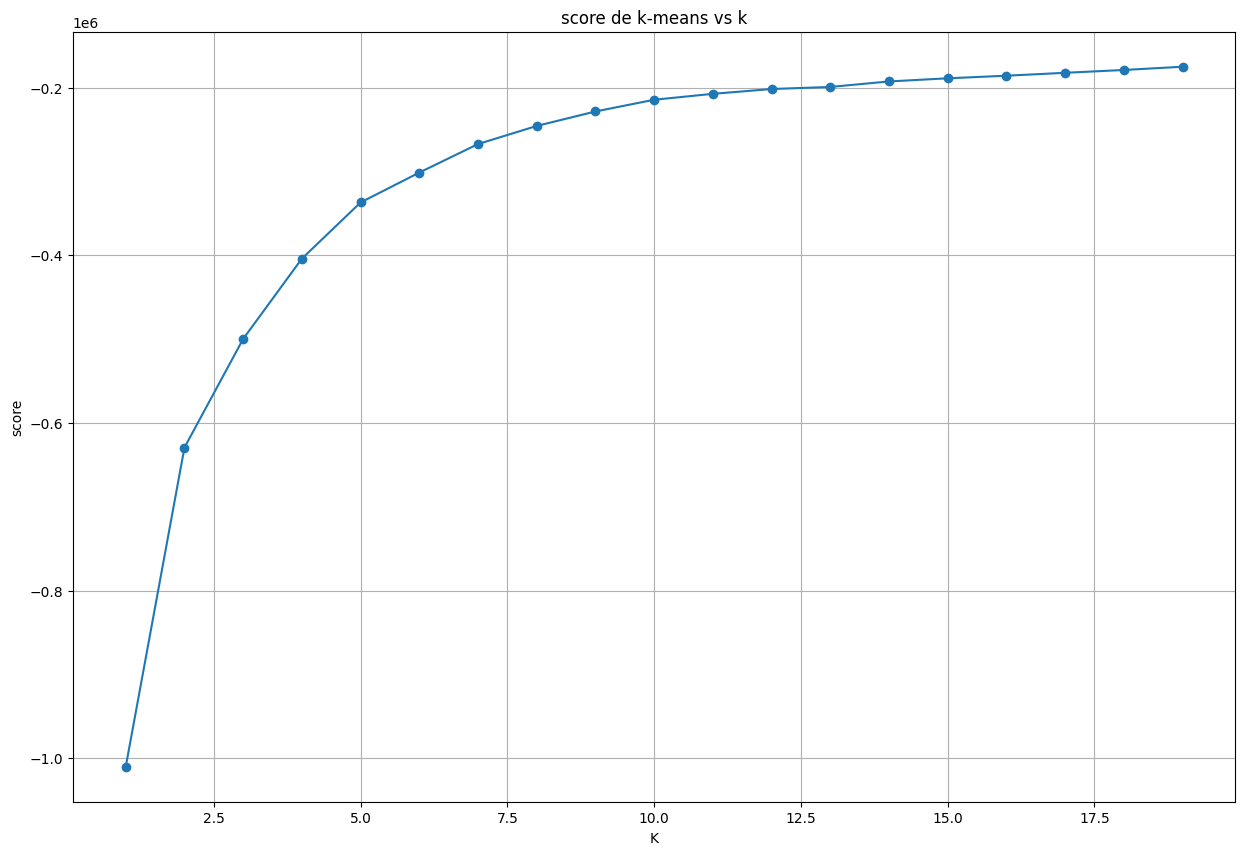

In [31]:
from sklearn.cluster import KMeans
ks = np.arange(1,20)
scores=list()
# Aplico KNN con varios Ks, y voy imprimiendo la performance y cuanto mejora el modeo
for K in ks:
  kmeans = KMeans(n_clusters=K)
  kmeans = kmeans.fit(spikesPC)
  score = kmeans.score(spikesPC)
  if K > 1:
    var = int(np.round(100*(scores[-1]-score)/scores[-1]))
  else:
    var = 0
  print(f'K {K} score {score:8.1f} variación relativa {var:2d}%')
  scores.append(score)

plt.plot(ks,scores,'o-')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('score')
plt.title('score de k-means vs k')
plt.show()

En el gráfico de arriba no parece haber un quiebre claro que indique el mejor K. Sin embargo, se ve que de K=10 a K=11, la variación relativa baja bastante, sugiriéndolo como posible valor. En el tutorial original utilizan una técnica de visualización 3D con la que concluyen que K=10 es lo apropiado, asique usaremos ese valor.

In [ ]:
# Ajustamos el modelo con 10 clusters a nuestros datos
km10 = KMeans(n_clusters=10, n_init=100, max_iter=100)
km10.fit(spikesPC)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Ahora con el modelo entrenado podemos obtener una clase, o neurona, correspondiente a cada spike

In [ ]:
# Obtengo el vector indicando la clase de cada spike
c10 = km10.fit_predict(spikesPC)
print("Ahora para cada spike tengo una clase asignada en un vector:")
print(c10)

Ahora para cada spike tengo una clase asignada en un vector:
[9 0 9 ... 5 4 2]


## Visualización de resultados

Ahora usamos la clasificación generada para separar los spikes. Abajo graficamos para las primeras 4 clases, todos los ejemplos correspondientes.

(-15.0, 20.0)

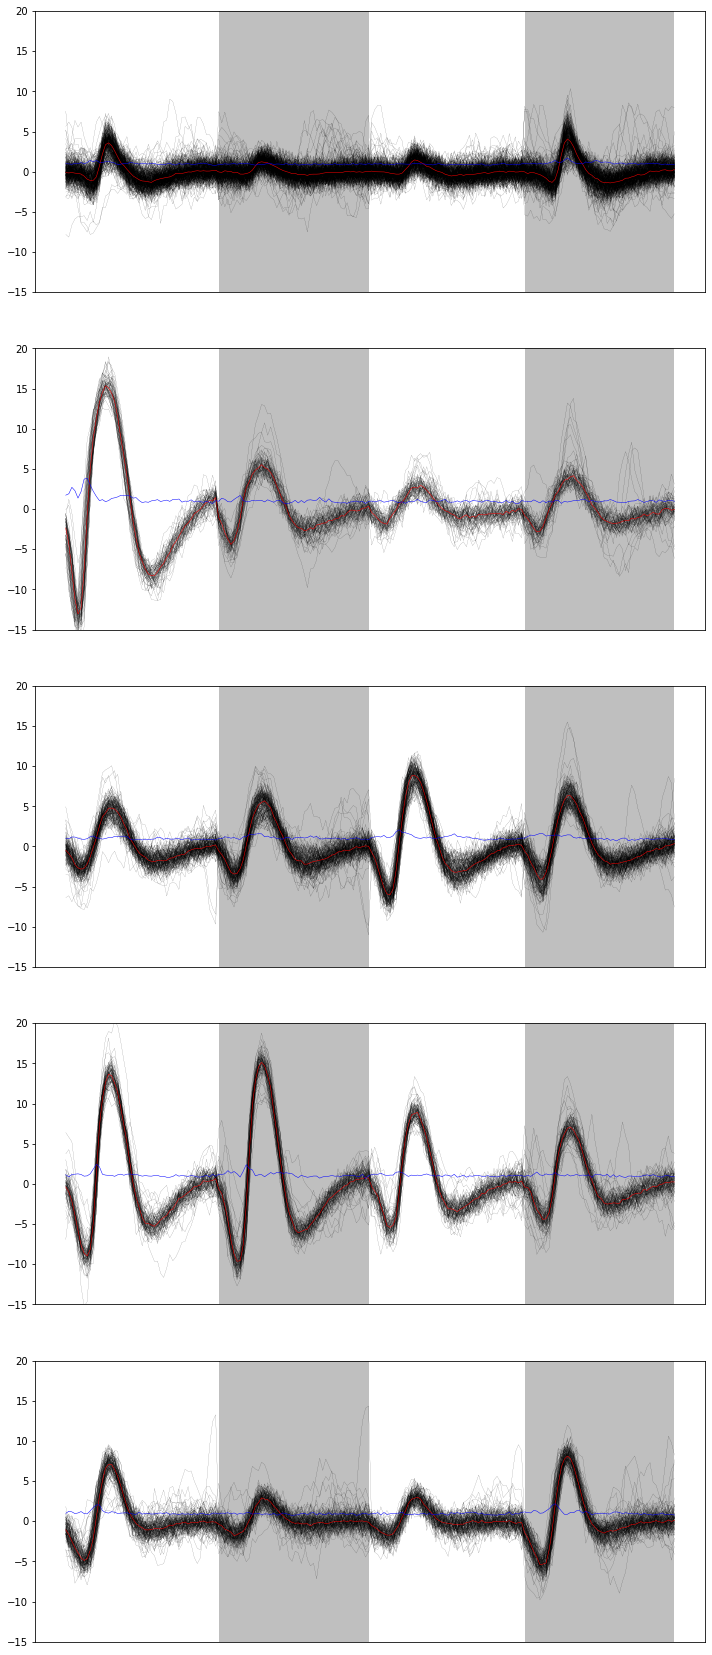

In [ ]:
plt.figure(figsize=(12,30))
plt.subplot(511)
swp.plot_events(goodEvts[np.array(c10) == 0,:])
plt.ylim([-15,20])
plt.subplot(512)
swp.plot_events(goodEvts[np.array(c10) == 1,:])
plt.ylim([-15,20])
plt.subplot(513)
swp.plot_events(goodEvts[np.array(c10) == 2,:])
plt.ylim([-15,20])
plt.subplot(514)
swp.plot_events(goodEvts[np.array(c10) == 3,:])
plt.ylim([-15,20])
plt.subplot(515)
swp.plot_events(goodEvts[np.array(c10) == 4,:])
plt.ylim([-15,20])

Vemos que luego de agrupados, los spikes tienen un comportamiento mucho más consistente entre sí, sugiriendo que pudimos capturar estructura relevante de los datos.

Abajo graficamos el scatter plot de los PC, pero mostrando las clases asignadas.

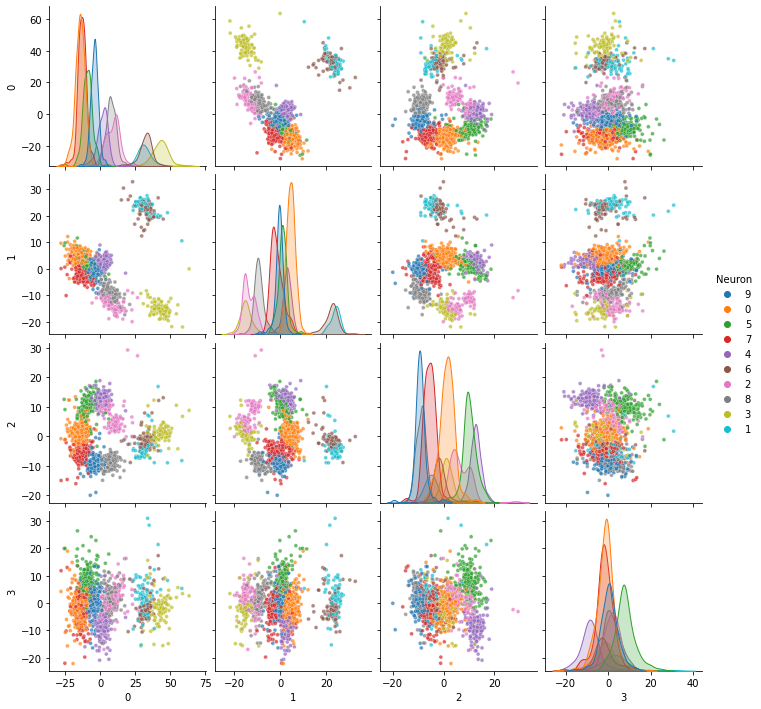

In [ ]:
import seaborn as sns
df = pd.DataFrame(spikesPC[:,0:4])
df['Neuron'] = [str(n) for n in c10]
sns.pairplot(df, hue='Neuron', plot_kws={"s": 15, "alpha": 0.7})

Finalmente, generamos un tipo de gráfica muy usada en neurociencias, un rasterplot. En este gráfico, se pone una neurona en cada fila, y luego se muestra en el tiempo cuando ocurren los spikes de las diferentes neuronas. Así puede verse la actividad neuronal de la población.

In [ ]:
# Primero separamos los tiempos de los spikes en una lista, donde cada
# elemento tiene los tiempos de una neurona
eventsList = []
for cl in range(10):
  eventsList.append(sp0[np.logical_and(c10==cl, sp0<40000)])

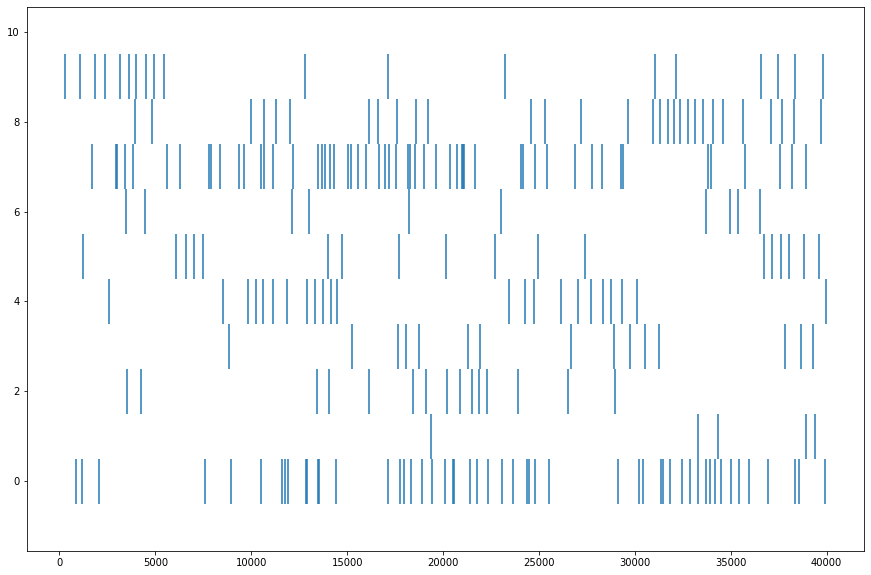

In [ ]:
from matplotlib.pyplot import eventplot
# Luego usamos la función eventplot para obtener la gráfica
eventCollection = eventplot(positions=eventsList)

Luego de este análisis, podemos buscar qué cosas codifican, o qué cosas afectan las diferentes neuronas en el comportamiento de la langosta.